# Case Study: Seattle Bike Share

In [72]:
from __future__ import division
import os

from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import qgrid
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
qgrid.nbinstall()
%matplotlib inline
plt.style.use(u'fivethirtyeight')

In [73]:
plt.style.available

[u'seaborn-darkgrid',
 u'seaborn-notebook',
 u'classic',
 u'seaborn-ticks',
 u'grayscale',
 u'bmh',
 u'seaborn-talk',
 u'dark_background',
 u'ggplot',
 u'fivethirtyeight',
 u'seaborn-colorblind',
 u'seaborn-deep',
 u'seaborn-whitegrid',
 u'seaborn-bright',
 u'seaborn-poster',
 u'seaborn-muted',
 u'seaborn-paper',
 u'seaborn-white',
 u'seaborn-pastel',
 u'seaborn-dark',
 u'seaborn-dark-palette']

In [74]:
# set working directory
path = "/Users/fernandogelin/Dropbox/pronto-challenge/data/"

In [75]:
# read files
station = pd.read_csv(os.path.join(path, '2015_station_data.csv'), 
                      parse_dates=['online'], 
                      infer_datetime_format=True)

trips = pd.read_csv(os.path.join(path, '2015_trip_data.csv'), 
                   parse_dates=['starttime', 'stoptime'], 
                   infer_datetime_format=True)

weather = pd.read_csv(os.path.join(path, '2015_weather_data.csv'), 
                      index_col='Date',
                      parse_dates=True)

In [76]:
ind = pd.DatetimeIndex(trips.starttime)
trips['date'] = ind.date.astype('datetime64')
trips['hour'] = ind.hour

In [77]:
weather.columns

Index([u'Max_Temperature_F', u'Mean_Temperature_F', u'Min_TemperatureF',
       u'Max_Dew_Point_F', u'MeanDew_Point_F', u'Min_Dewpoint_F',
       u'Max_Humidity', u'Mean_Humidity ', u'Min_Humidity ',
       u'Max_Sea_Level_Pressure_In ', u'Mean_Sea_Level_Pressure_In ',
       u'Min_Sea_Level_Pressure_In ', u'Max_Visibility_Miles ',
       u'Mean_Visibility_Miles ', u'Min_Visibility_Miles ',
       u'Max_Wind_Speed_MPH ', u'Mean_Wind_Speed_MPH ', u'Max_Gust_Speed_MPH',
       u'Precipitation_In ', u'Events'],
      dtype='object')

In [78]:
weather[[u'Mean_Temperature_F', u'Precipitation_In ', u'Mean_Humidity ', u'Events']].head()

,Mean_Temperature_F,Precipitation_In,Mean_Humidity,Events
Date,,,,
2014-10-13,62,0.00,68,Rain
2014-10-14,59,0.11,78,Rain
2014-10-15,58,0.45,77,Rain
2014-10-16,61,0.00,61,Rain
2014-10-17,60,0.14,72,Rain


# Rides by day of week

In [79]:
# Count trips by date
by_date = trips.pivot_table('trip_id', aggfunc='count',
                            index='date',
                            columns='usertype')

# Count trips by weekday
weekly = by_date.pivot_table(['Annual Member', 'Short-Term Pass Holder'],
                             index=by_date.index.weekofyear,
                             columns=by_date.index.dayofweek)

In [86]:
def line_by_date(usertype):
    if usertype == 'Short-Term Pass Holder':
        color = 'red'
    else: 
        color = 'blue'
    fig, bx = plt.subplots(figsize=(16, 6))
    bx.plot(by_date.index, by_date[usertype], color=color, linewidth=2)

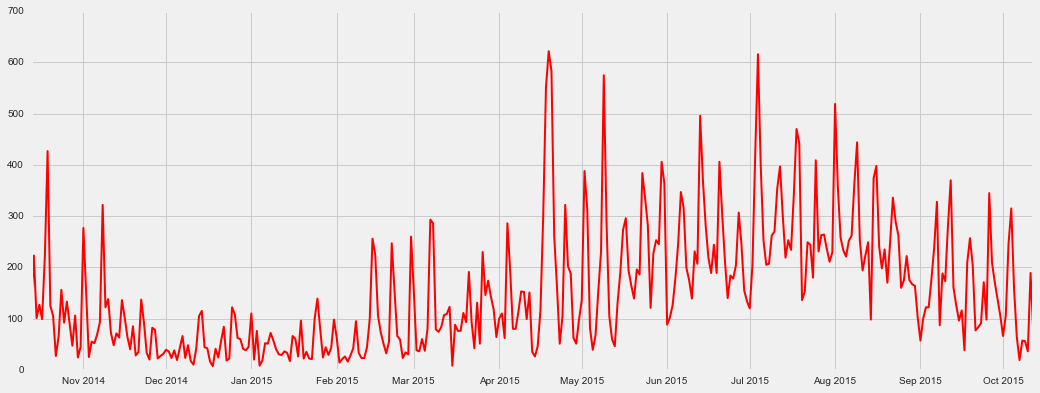

In [87]:
interact(line_by_date, usertype = ['Annual Member', 'Short-Term Pass Holder'])

In [39]:
trips['day_of_week'] = trips['starttime'].apply(lambda x: x.weekday())

In [40]:
week_count = trips.groupby(['day_of_week', 'usertype'], as_index=False).count()

In [41]:
week_count = week_count[['day_of_week', 'usertype', 'trip_id']]

/Users/fernandogelin/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


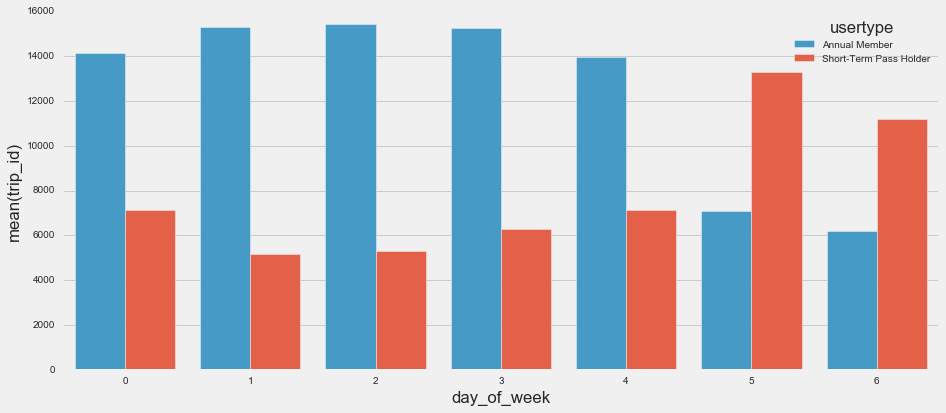

In [42]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(ax=ax, x='day_of_week', y='trip_id', hue='usertype', data=week_count)

# Rides by time of day

In [43]:
trips['weekday'] = trips['starttime'].apply(lambda x: x.weekday())
trips['is_weekend'] = trips['weekday'].apply(lambda x: True if x > 4 else False)

In [44]:
weekday_hour = (trips
                .groupby(['hour','usertype', 'is_weekend'], as_index=False)
                .count()[['hour','usertype', 'is_weekend','trip_id']])

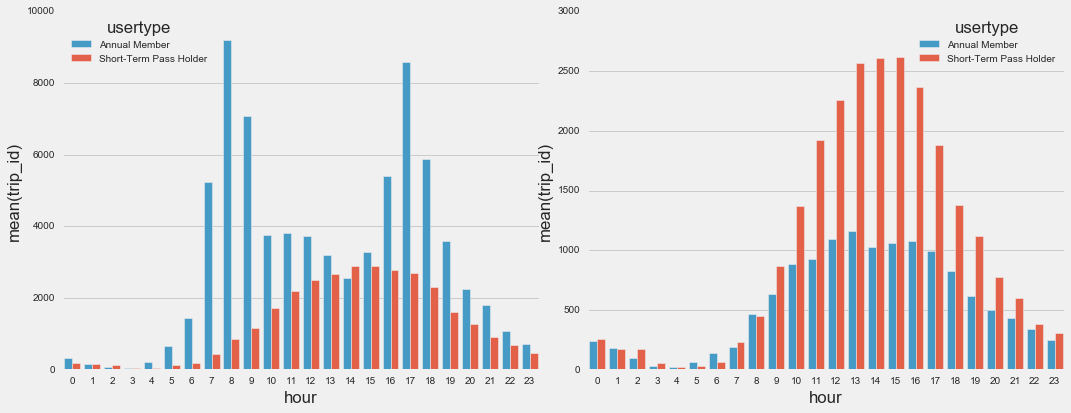

In [45]:
fig, ax1 = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.1)
weekday = weekday_hour[weekday_hour['is_weekend'] == False]
weekend = weekday_hour[weekday_hour['is_weekend'] == True]
sns.barplot(weekday['hour'], weekday['trip_id'], hue=weekday['usertype'], ax=ax1[0])
sns.barplot(weekend['hour'], weekend['trip_id'], hue=weekend['usertype'], ax=ax1[1])

In [46]:
terminal = list(station['terminal'])
lat = list(station['lat'])
lon = list(station['long'])
lat_map = {}
long_map = {}
for i in xrange(len(terminal)):
    lat_map[terminal[i]] = lat[i]
    long_map[terminal[i]] = lon[i]

In [47]:
trips['from_lat'] = trips['from_station_id'].map(lat_map)
trips['from_long'] = trips['from_station_id'].map(long_map)
trips['to_lat'] = trips['to_station_id'].map(lat_map)
trips['to_long'] = trips['to_station_id'].map(long_map)

# Trend with weather

In [48]:
by_date = trips.groupby(['date', 'usertype'])['trip_id'].count()
by_date.name = 'count'
by_date = by_date.reset_index('usertype').join(weather)
by_date['weekend'] = (by_date.index.dayofweek >= 5)

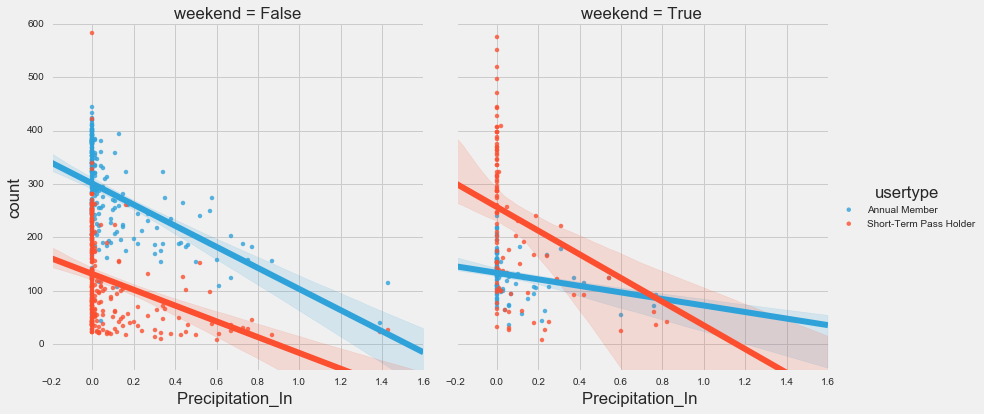

In [49]:
g = sns.FacetGrid(by_date, col="weekend", hue='usertype', size=6)
g.map(sns.regplot, "Precipitation_In ", "count")
g.axes[0, 0].set_ylim(-50, 600)
g.add_legend()

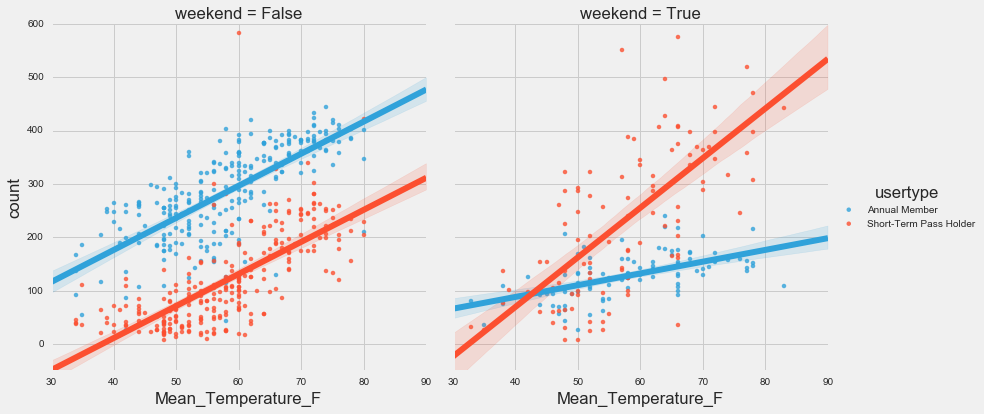

In [50]:
g = sns.FacetGrid(by_date, col="weekend", hue='usertype', size=6)
g.map(sns.regplot, "Mean_Temperature_F", "count", fit_reg=True)
g.add_legend()
g.axes[0, 0].set_ylim(-50, 600)
sns.set_style({'axes.linewidth': 1.0})